# 3D Phantom

We create a Magritte model from a snapshot of 3D Phantom hydrodynamics simulation.
The hydro model was kindly provided by Jolien Malfait.
Currently, the Phantom binary files can not yet be used directly to extract the snapshot data.
Hence we use the corresponding `.ascii` files.

## Setup

Import the required functionalty.

In [1]:
#original file: 3_create_Phantom_3D.ipynb

In [2]:
import magritte.setup as setup                # Model setup
import magritte.core  as magritte             # Core functionality
import numpy          as np                   # Data structures
import warnings                               # Hide warnings
warnings.filterwarnings('ignore')             # especially for yt
import yt                                     # 3D plotting
import os

from tqdm          import tqdm                # Progress bars
from astropy       import constants, units    # Unit conversions
from scipy.spatial import Delaunay, cKDTree   # Finding neighbors
from yt.funcs      import mylog               # To avoid yt output 
mylog.setLevel(40)                            # as error messages

ModuleNotFoundError: No module named 'magritte'

In [3]:
import h5py
from scipy.interpolate import interp1d
import time

Define a working directory (you will have to change this; it must be an **absolute path**).

In [4]:
wdir = "/home/arnoutc/MasterThesis/Magritte_output/"

Create the working directory.

In [5]:
!mkdir -p $wdir

Define file names.

In [6]:
files = ['NaCl26-25_deprojected_cube_vinf_2596_x4y4v10.h5'
         , 'NaCl26-25_deprojected_cube_vinf_2596_x6y6v12.h5'
         , 'NaCl27-26_deprojected_cube_vinf_2596_x4y4v10.h5'
         , 'NaCl27-26_deprojected_cube_vinf_2596_x6y6v12.h5'
        ]
num = 1

line_index = [25, 25, 26, 26][num] # [877, 877, 891, 891][num] #
filename = os.path.join(wdir, files[num])
print(files[num])

NaCl26-25_deprojected_cube_vinf_2596_x6y6v12.h5


In [7]:
#input_file = os.path.join(wdir, 'model_test.ascii')   # 
temp = files[num].split('.')[0].split('_')
model_file = os.path.join(wdir, temp[0]+'_'+temp[-1]+'_'+'model.hdf5' )   # Resulting Magritte model savefilename
lamda_file = os.path.join(wdir, '23Na-35Cl__Barton-ExoMol.dat') # Line data file
print(model_file)
print(lamda_file)

/home/arnoutc/MasterThesis/Magritte_output/NaCl26-25_x6y6v12_model.hdf5
/home/arnoutc/MasterThesis/Magritte_output/23Na-35Cl__Barton-ExoMol.dat


We use a snapshot and data file that can be downloaded with the following links.

In [8]:
#input_link = "https://owncloud.ster.kuleuven.be/index.php/s/6mCZjZ2erTsXq5Y/download"
#lamda_link = "https://home.strw.leidenuniv.nl/~moldata/datafiles/co.dat"

Dowload the snapshot and the linedata (``%%capture`` is just used to suppress the output).

In [9]:
#%%capture
#!wget $input_link --output-document $input_file
#!wget $lamda_link --output-document $lamda_file

## Extract data

The script below extracts the required data from the snapshot `.ascii` file.

In [8]:
D = 260*units.pc#pc
vi = 3*units.km/units.s #km/s
vinf = 25.96*units.km/units.s #km/s
Ri = 2.38e14*units.cm #cm
beta = 1.5
vLSR = 34*units.km/units.s #km/s
Mloss = 5e-6*units.Msun/units.yr #Msun/yr
Rstar = 3.8e13*units.cm #cm
Tstar = 2100 #K

NA = 6.022e23
mH2 = (2.016/NA*units.g).to(units.kg)

def n(r, Mdot = Mloss, m = mH2):
    v = velprofile(r)
    v = v.to(units.cm/units.s)
    r = r*units.cm
    return (Mdot.to(units.kg/units.s) / (4 * np.pi * r**2 * v) / m).value

#r in cm
def velprofile(r, vi = vi, vinf = vinf, Ri = Ri, beta = beta):
    r = ( (r*units.AU).to(units.cm) ).value
    brackets = 1 - Ri.value/r
    sign = np.sign(r)
    
    if isinstance(r, np.ndarray):
        sign[np.where(sign == 0)] = 1
        return ( vi + (vinf - vi) * brackets.clip(min=0)**beta ) * sign
    else:
        if sign == 0:
            sign = 1
        return ( vi + (vinf - vi) * max(brackets, 0)**beta ) * sign

In [9]:
def vrad_to_vxyz(v, x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.zeros_like(x)
    for i in range(len(x)):
        if x[i] > 0:
            phi[i] = np.arctan(y[i]/x[i])
        elif x[i] < 0:
            if y[i] >= 0:
                phi[i] = np.arctan(y[i]/x[i]) + np.pi
            else:
                phi[i] = np.arctan(y[i]/x[i]) - np.pi
        else:
            if y[i] > 0:
                phi[i] = np.pi/2
            elif y[i] < 0:
                phi[i] = - np.pi/2
            else:
                phi[i] = 0
    vx = v*np.cos(phi)*np.sin(theta)
    vy = v*np.sin(phi)*np.sin(theta)
    vz = v*np.cos(theta)
    return vx, vy, vz

In [10]:
with h5py.File(filename, 'r') as hf:
    print(list(hf.keys()))
    x = np.array(hf['X'])
    y = np.array(hf['Y'])
    z = np.array(hf['Z'])
    v = ((np.array(hf['V']) * units.km/units.s).to(units.cm/units.s)).value
    I = np.array(hf['I'])

['Clump_index', 'I', 'Type', 'V', 'X', 'Y', 'Z']


In [11]:
# Read the Phantom ascii file
#(x,y,z, h, rho, vx,vy,vz, u) = np.loadtxt(input_file, skiprows=14, usecols=(0,1,2,4,5,6,7,8,9), unpack=True)

# Constants that can be read from ascii file
velocity_cte = 2.9784608e+06  
density_cte  = 5.9410314e-07
energy_cte   = 8.8712277e+12

r = np.sqrt(x**2 + y**2 + z**2)
valid = np.where(((r*units.AU).to(units.cm)).value > Rstar.value)[0]
r = r[valid]
x = x[valid]
y = y[valid]
z = z[valid]
v = v[valid]
I = I[valid]

print("splitting velocity")
vx, vy, vz = vrad_to_vxyz(v, x, y, z)

# Extract the number of points
npoints = len(x)

# Convert rho (total density) to abundances
print("calculating densities")
nH2 = n(r)
Imax = max(I)
solarNaCl = 6.3e-7
nNaCl = I / Imax * solarNaCl

# Convenience arrays
print("creating arrays")
zeros = np.zeros(npoints)
ones  = np.ones (npoints)

position = np.array((x, y, z )).transpose()
velocity = np.array((vx,vy,vz)).transpose()

# Convert units
print("converting units")
position *= constants.au.si.value                    # Convert au to m
velocity *= (velocity_cte / constants.c.cgs.value)   # cm/s to c fraction

splitting velocity
calculating densities
creating arrays
converting units


In [22]:
velocity_cte

2978460.8

In [13]:
max(velocity.T[0])

116.99953802560388

In [15]:
print(npoints)

2004200


In [14]:
redo = False

wdir_files = os.listdir()
temp = files[num].split('_')
Delaunay_file_name = 'Delaunay_{0}_{1}'.format(temp[0], temp[-1])
Delaunay_file = os.path.join(wdir, Delaunay_file_name)
if Delaunay_file_name in wdir_files and redo == False:
    with h5py.File(Delaunay_file, 'r') as hf:
        nbs = np.array(hf['nbs'])
        n_nbs = np.array(hf['n_nbs'])
else:
    # Extract Delaunay vertices (= Voronoi neighbors)
    start_time = time.time()
    delaunay = Delaunay(position) #positions = list of 3d points
    stop_time = time.time()
    dt = stop_time - start_time
    print("Delaunay calculations took {0} seconds, which corresponds to {1} minutes, or {2} hours".format(dt, dt/60, dt/60/60))
    (indptr, indices) = delaunay.vertex_neighbor_vertices #finds nearest neigbhours of each point
    neighbors = [indices[indptr[k]:indptr[k+1]] for k in range(npoints)] #indices of neighbours of points
    nbs       = [n for sublist in neighbors for n in sublist] #linear neigbhours
    n_nbs     = [len(sublist) for sublist in neighbors] #number of neighbours    
    with h5py.File(Delaunay_file, 'w') as hf:
        hf.create_dataset('nbs', data=nbs)
        hf.create_dataset('n_nbs', data=n_nbs)

Delaunay calculations took 1666.524341583252 seconds, which corresponds to 27.7754056930542 minutes, or 0.46292342821757 hours


In [16]:
# # Compute the indices of the boundary particles of the mesh #--> currently is specific for SPH model
print("Identifying boundary particles")
def find1Dbounds(arr):
    mins = np.where(arr == min(arr))[0]
    maxs = np.where(arr == max(arr))[0]
    return mins, maxs

xmin, xmax = find1Dbounds(x)
ymin, ymax = find1Dbounds(y)
vmin, vmax = find1Dbounds(v)

boundary = np.array(list(set( list(xmin) + list(xmax) + list(ymin) + list(ymax) + list(vmin) + list(vmax) ) ) )

print("Calculating Temperature profile")
temppath = os.path.join(wdir, 'iktau-co-04-grid-38.temp')
r_, T_ = np.loadtxt(temppath).T #r in cm, T in K
r_ = np.array([Rstar.value] + list(r_))
T_ = np.array([Tstar] + list(T_))
Tfunction = interp1d(r_, T_)
tmp = Tfunction(((r*units.AU).to(units.cm)).value)

# Cut-off temperatures below 2.725 K
tmp[tmp<2.725] = 2.725


# Define turbulence at 150 m/s
trb = (150.0/constants.c.si.value)**2 * ones

Identifying boundary particles
Calculating Temperature profile


## Create model

Now all data is read, we can use it to construct a Magritte model.

<div class="alert alert-warning">

Warning

Since we do not aim to do self-consistent non-LTE simulations in these examples, we only consider the first radiative transition of CO (J=1-0). To consider all transitions, use `setup.set_linedata_from_LAMDA_file` as in the commented line below it.
We also only consider 2 rays here (up and down the direction we want to image). To consider all directions, comment out the indecated lines and use `setup.set_uniform_rays` as in the commented line below.
    
</div>

In [17]:
model = magritte.Model ()                              # Create model object

model.parameters.set_model_name         (model_file)   # Magritte model file
model.parameters.set_spherical_symmetry (False)        # No spherical symmetry
model.parameters.set_dimension          (3)            # This is a 3D model
model.parameters.set_npoints            (npoints)      # Number of points
model.parameters.set_nrays              (2)            # Number of rays  
model.parameters.set_nspecs             (5)            # Number of species (min. 5)
model.parameters.set_nlspecs            (1)            # Number of line species
model.parameters.set_nquads             (31)           # Number of quadrature points --> num freq bins per transition
model.parameters.set_pop_prec           (1.0e-6)       # Pops. convergence criterion

model.geometry.points.position.set(position) #vector of (x,y,z): (n, 3)
model.geometry.points.velocity.set(velocity) #beta-velocity law #need to vecotrs # unit: [v/c]

model.geometry.points.  neighbors.set(  nbs)
model.geometry.points.n_neighbors.set(n_nbs)

model.chemistry.species.abundance = np.array((zeros, nNaCl, nH2, zeros, ones)).T
model.chemistry.species.symbol    = ['dummy0', 'NaCl', 'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set(tmp)
model.thermodynamics.turbulence.vturb2.set(trb) #(~1km/s/c)**2 [(v/c)**2]

model.parameters.set_nboundary(boundary.shape[0])
model.geometry.boundary.boundary2point.set(boundary)

direction = np.array([[0,0,-1], [0,0,+1]])            # Comment out to use all directions #first one is from where were looking, second one is -(first one)
model.geometry.rays.direction.set(direction)          # Comment out to use all directions
model.geometry.rays.weight   .set(0.5 * np.ones(2))   # Comment out to use all directions

# model = setup.set_uniform_rays            (model)   # Uncomment to use all directions
model = setup.set_boundary_condition_CMB  (model)
model = setup.set_linedata_from_LAMDA_file(model, lamda_file, {'considered transitions': [line_index-1]}) #--> specify relevant line that we're looking for (very important) (this should be a NaCl line) 
##                                                                                                     (take (index from lamda file-1))
# model = setup.set_linedata_from_LAMDA_file(model, lamda_file)   # Consider all transitions
model = setup.set_quadrature              (model)

model.write()

Not considering all radiative transitions on the data file but only the specified ones!
Writing parameters...
Writing rays...
Writing boundary...
Writing chemistry...
Writing species...
Writing thermodynamics...
Writing temperature...
Writing turbulence...
Writing lines...
Writing lineProducingSpecies...
Writing linedata...
ncolpoar = 1
--- colpoar = 0
Writing collisionPartner...
(l, c) = 0, 0
Writing quadrature...
Writing populations...
Writing radiation...
Writing frequencies...


## Plot model

Load the data in a `yt` unstructured mesh.

In [19]:
ds = yt.load_unstructured_mesh(
    connectivity = delaunay.simplices.astype(np.int64),
    coordinates  = delaunay.points.astype(np.float64) * 100.0, # yt expects cm not m 
    node_data    = {('connect1', 'n'): nNaCl[delaunay.simplices].astype(np.float64)}
)

Plot a slice through the mesh orthogonal to the z-axis.


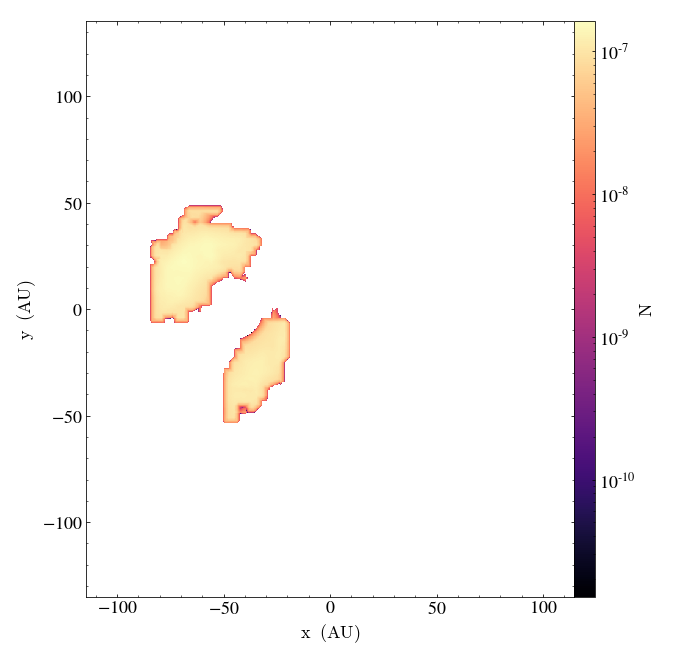

In [20]:
sl = yt.SlicePlot (ds, 'z', 'n')
sl.set_cmap       ('n', 'magma')
sl.zoom           (1.1)

Show mesh on the plot.


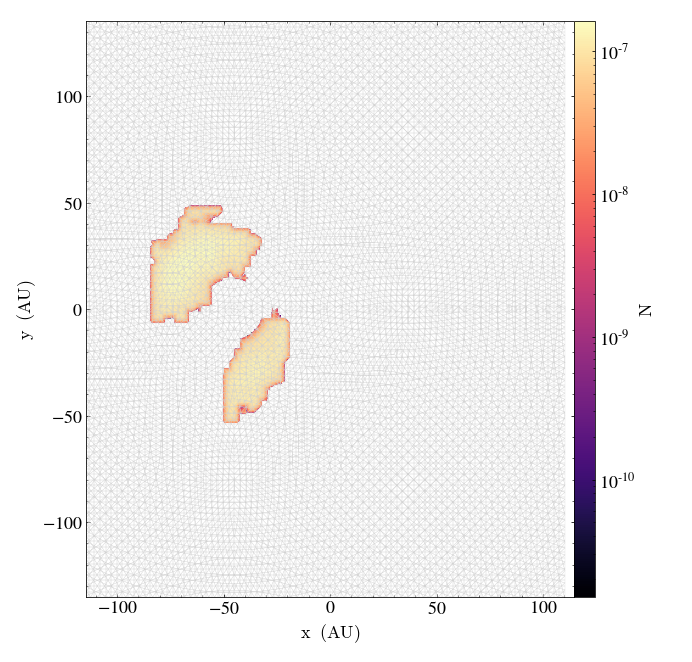

In [21]:
sl = yt.SlicePlot      (ds, 'z', 'n')
sl.set_cmap            ('n', 'magma')
sl.zoom                (1.1)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})

In the [next example](4_reduce_Phantom_3D.ipynb) we demonstrate how to reduce this model as in [De Ceuster et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.499.5194D/abstract).